### The purpose of this project is to predict student attendance rates for various K-12 school districts in Texas during the first few months of the 2020-2021 academic school year.

### This project will try to determine the effects of Covid-19 cases, demographic data, and the weather on student attendance rates during the pandemic.

### Although the data set includes dates, I will not interpret the data set using a time series model. I will only use the day of the week as a categorical/dummy variable along with the rest of the non-time-related variables for my regressor models.

#### The source of the data set is: https://www.kaggle.com/chrisiortiz/school-attendance-in-texas-covid-weather-ses

In [3]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

### Read in the School Level Data. This is the data set I want to work on.

In [4]:
local_csv = './SchoolLevelData_V3.csv'
df = pd.read_csv(local_csv)
df.head()

,Unnamed: 0,Day,Weekday,School,SchoolType,School_Zip,District,DistrictNumber,County,TEA_Description,...,Two,Hispanic,PercentWithoutDegree,PercentFamilyPoverty,UnemploymentRate,Latitude,Longitude,PRCP,TMAX,TMIN
0,1,2020-08-17,Monday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,77901,Floyd,Rural,...,0.4,57.72,26.6,15.1,5.8,33.941748,-101.30072,0.0,95.0,68.0
1,2,2020-08-18,Tuesday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,77901,Floyd,Rural,...,0.4,57.72,26.6,15.1,5.8,33.941748,-101.30072,0.0,88.0,65.0
2,3,2020-08-19,Wednesday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,77901,Floyd,Rural,...,0.4,57.72,26.6,15.1,5.8,33.941748,-101.30072,0.0,92.0,65.0
3,4,2020-08-20,Thursday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,77901,Floyd,Rural,...,0.4,57.72,26.6,15.1,5.8,33.941748,-101.30072,0.0,92.0,68.0
4,5,2020-08-21,Friday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,77901,Floyd,Rural,...,0.4,57.72,26.6,15.1,5.8,33.941748,-101.30072,0.0,89.0,66.0


# Exploratory Data Analysis

In [3]:
df.columns

Index(['Unnamed: 0', 'Day', 'Weekday', 'School', 'SchoolType', 'School_Zip',
       'District', 'DistrictNumber', 'County', 'TEA_Description',
       'NCES_Description', 'MetroStatus', 'AttendancePercent', 'AbsentPercent',
       'CovidTotalCountyCases', 'CovidCountyPercentIncrease',
       'CovidTotalStateCases', 'CovidStatePercentIncrease',
       'HousholdMediumIncome', 'Population', 'White', 'Black', 'Native',
       'Asian', 'Islander', 'Other', 'Two', 'Hispanic', 'PercentWithoutDegree',
       'PercentFamilyPoverty', 'UnemploymentRate', 'Latitude', 'Longitude',
       'PRCP', 'TMAX', 'TMIN'],
      dtype='object')

### I will drop the columns that are redundant or unnecessary for my data set.
#### (More columns may be dropped later when I create my X matrix.)

In [4]:
drop_columns = ['Unnamed: 0','DistrictNumber','AbsentPercent','TEA_Description',
                'CovidCountyPercentIncrease', 'CovidStatePercentIncrease', 'Latitude', 'Longitude']
# use 'Day', 'School', and 'School_Zip' to fill in missing values
df.drop(drop_columns, axis=1, inplace=True)
df.head()

,Day,Weekday,School,SchoolType,School_Zip,District,County,NCES_Description,MetroStatus,AttendancePercent,...,Islander,Other,Two,Hispanic,PercentWithoutDegree,PercentFamilyPoverty,UnemploymentRate,PRCP,TMAX,TMIN
0,2020-08-17,Monday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,Floyd,Rural-Fringe,Non-Metro,100.00,...,0.0,0.0,0.4,57.72,26.6,15.1,5.8,0.0,95.0,68.0
1,2020-08-18,Tuesday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,Floyd,Rural-Fringe,Non-Metro,100.00,...,0.0,0.0,0.4,57.72,26.6,15.1,5.8,0.0,88.0,65.0
2,2020-08-19,Wednesday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,Floyd,Rural-Fringe,Non-Metro,100.00,...,0.0,0.0,0.4,57.72,26.6,15.1,5.8,0.0,92.0,65.0
3,2020-08-20,Thursday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,Floyd,Rural-Fringe,Non-Metro,98.81,...,0.0,0.0,0.4,57.72,26.6,15.1,5.8,0.0,92.0,68.0
4,2020-08-21,Friday,A B Duncan Collegiate Elementary,Elementary,79235,FLOYDADA ISD,Floyd,Rural-Fringe,Non-Metro,98.32,...,0.0,0.0,0.4,57.72,26.6,15.1,5.8,0.0,89.0,66.0


In [5]:
df.shape

(38542, 28)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38542 entries, 0 to 38541
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Day                    38542 non-null  object 
 1   Weekday                38542 non-null  object 
 2   School                 38542 non-null  object 
 3   SchoolType             38542 non-null  object 
 4   School_Zip             38542 non-null  int64  
 5   District               38542 non-null  object 
 6   County                 38542 non-null  object 
 7   NCES_Description       38542 non-null  object 
 8   MetroStatus            38542 non-null  object 
 9   AttendancePercent      38445 non-null  float64
 10  CovidTotalCountyCases  38542 non-null  int64  
 11  CovidTotalStateCases   38542 non-null  int64  
 12  HousholdMediumIncome   38333 non-null  float64
 13  Population             38333 non-null  float64
 14  White                  38333 non-null  float64
 15  Bl

### Here I try to fill in missing values if possible.

In [7]:
df.isnull().sum()

Day                        0
Weekday                    0
School                     0
SchoolType                 0
School_Zip                 0
District                   0
County                     0
NCES_Description           0
MetroStatus                0
AttendancePercent         97
CovidTotalCountyCases      0
CovidTotalStateCases       0
HousholdMediumIncome     209
Population               209
White                    209
Black                    209
Native                   209
Asian                    209
Islander                 209
Other                    209
Two                      209
Hispanic                 209
PercentWithoutDegree     209
PercentFamilyPoverty     209
UnemploymentRate         209
PRCP                     171
TMAX                     631
TMIN                     631
dtype: int64

In [8]:
# September 7, 2020 was Labor Day.
# October 12, 2020 was Columbus Day.
# September 22, 2020 was likely another holiday or non-instruction day.
# These days effectively count as "weekends" so I'll drop them from my dataset later.
df[df['AttendancePercent'].isnull()].groupby('Day').count()

,Weekday,School,SchoolType,School_Zip,District,County,NCES_Description,MetroStatus,AttendancePercent,CovidTotalCountyCases,...,Islander,Other,Two,Hispanic,PercentWithoutDegree,PercentFamilyPoverty,UnemploymentRate,PRCP,TMAX,TMIN
Day,,,,,,,,,,,,,,,,,,,,,
2020-09-07,6,6,6,6,6,6,6,6,0,6,...,6,6,6,6,6,6,6,6,6,6
2020-09-22,85,85,85,85,85,85,85,85,0,85,...,84,84,84,84,84,84,84,85,85,85
2020-10-12,6,6,6,6,6,6,6,6,0,6,...,6,6,6,6,6,6,6,4,4,4


In [9]:
# These are the days which contain some null values of PRCP.
# I'll replace all null PRCP values with the mean PRCP value for that particular day.
PRCP_null_days = df[df['PRCP'].isnull()].groupby('Day').count().index
PRCP_null_days

Index(['2020-08-26', '2020-08-27', '2020-09-15', '2020-10-12', '2020-10-13',
       '2020-10-26', '2020-10-30', '2020-11-02'],
      dtype='object', name='Day')

In [10]:
for day in PRCP_null_days:
    temp = df.loc[df['Day'] == day]
    prcp_mean = temp['PRCP'].mean()
    temp['PRCP'].fillna(value=prcp_mean, inplace=True)
    df.update(other=temp, overwrite=False)

df[df['PRCP'].isnull()].groupby('Day').count()

/Users/eshnajain/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Weekday,School,SchoolType,School_Zip,District,County,NCES_Description,MetroStatus,AttendancePercent,CovidTotalCountyCases,...,Islander,Other,Two,Hispanic,PercentWithoutDegree,PercentFamilyPoverty,UnemploymentRate,PRCP,TMAX,TMIN
Day,,,,,,,,,,,,,,,,,,,,,


In [11]:
# Do the same for the missing TMAX and TMIN values.
TMAX_null_days = df[df['TMAX'].isnull()].groupby('Day').count().index

for day in TMAX_null_days:
    temp = df.loc[df['Day'] == day]
    tmax_mean = temp['TMAX'].mean()
    temp['TMAX'].fillna(value=tmax_mean, inplace=True)
    df.update(other=temp, overwrite=False)

TMIN_null_days = df[df['TMIN'].isnull()].groupby('Day').count().index

for day in TMIN_null_days:
    temp = df.loc[df['Day'] == day]
    tmin_mean = temp['TMIN'].mean()
    temp['TMIN'].fillna(value=tmin_mean, inplace=True)
    df.update(other=temp, overwrite=False)

df.isnull().sum()

/Users/eshnajain/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Day                        0
Weekday                    0
School                     0
SchoolType                 0
School_Zip                 0
District                   0
County                     0
NCES_Description           0
MetroStatus                0
AttendancePercent         97
CovidTotalCountyCases      0
CovidTotalStateCases       0
HousholdMediumIncome     209
Population               209
White                    209
Black                    209
Native                   209
Asian                    209
Islander                 209
Other                    209
Two                      209
Hispanic                 209
PercentWithoutDegree     209
PercentFamilyPoverty     209
UnemploymentRate         209
PRCP                       0
TMAX                       0
TMIN                       0
dtype: int64

In [12]:
# All 4 of these schools account for the missing 209 demographic data
df[df['HousholdMediumIncome'].isnull()].groupby('School').max()

,Day,Weekday,SchoolType,School_Zip,District,County,NCES_Description,MetroStatus,AttendancePercent,CovidTotalCountyCases,...,Islander,Other,Two,Hispanic,PercentWithoutDegree,PercentFamilyPoverty,UnemploymentRate,PRCP,TMAX,TMIN
School,,,,,,,,,,,,,,,,,,,,,
Adams Junior High,2020-12-02,Wednesday,Middle,77492,KATY ISD,Harris,Suburb-Large,Metro,100.00,194152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.32,99.0,84.0
Juvenile Justice AEP,2020-11-13,Wednesday,High,5790,DALLAS ISD,Dallas,City-Large,Metro,83.33,123768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,92.0,75.0
Raul Quintanilla Sr Middle School Stem Academy,2020-11-20,Wednesday,Middle,5790,DALLAS ISD,Dallas,City-Large,Metro,97.68,134909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,92.0,75.0
Salyards Middle School,2020-11-03,Wednesday,Middle,77269,CYPRESS-FAIRBANKS ISD,Harris,Suburb-Large,Metro,100.00,164743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.32,97.0,80.0


In [13]:
# These schools are given incorrect zip codes that will be replaced by their correct zip codes.
# The correct zip code for each school address was found online via the school's website.

corrected_zip_schools = {"Adams Junior High" : 77441,
                         "Juvenile Justice AEP" : 75212,
                         "Raul Quintanilla Sr Middle School Stem Academy" : 75211,
                         "Salyards Middle School" : 77433}

In [14]:
# I will map the school with the missing demographic data with
# another school's demographic data that has the correct zip code

for school, zipcode in corrected_zip_schools.items():
    series_map = df.query('School_Zip == @zipcode').iloc[0,12:25]
    temp = df.query('School == @school')
    temp.fillna(value=series_map, inplace=True)
    temp['School_Zip'] = int(zipcode)
    df.update(other=temp, overwrite=True)

df.isnull().sum()

/Users/eshnajain/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-14-138a52190bc2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['School_Zip'] = int(zipcode)


Day                       0
Weekday                   0
School                    0
SchoolType                0
School_Zip                0
District                  0
County                    0
NCES_Description          0
MetroStatus               0
AttendancePercent        97
CovidTotalCountyCases     0
CovidTotalStateCases      0
HousholdMediumIncome      0
Population                0
White                     0
Black                     0
Native                    0
Asian                     0
Islander                  0
Other                     0
Two                       0
Hispanic                  0
PercentWithoutDegree      0
PercentFamilyPoverty      0
UnemploymentRate          0
PRCP                      0
TMAX                      0
TMIN                      0
dtype: int64

In [15]:
# Dropping the remaining missing values (non-instruction days and therefore no need for attendance).
df.dropna(axis = 0, inplace = True)

# Modeling

### Now that all the missing values are accounted for, I need to make my X matrix and y vector.

In [16]:
y = df['AttendancePercent']
X = df.drop(['Day', 'School', 'School_Zip', 'AttendancePercent'], axis=1)

In [17]:
X = pd.get_dummies(X)
X

,CovidTotalCountyCases,CovidTotalStateCases,HousholdMediumIncome,Population,White,Black,Native,Asian,Islander,Other,...,County_Dallas,County_Floyd,County_Harris,County_Tarrant,NCES_Description_City-Large,NCES_Description_Rural-Distant,NCES_Description_Rural-Fringe,NCES_Description_Suburb-Large,MetroStatus_Metro,MetroStatus_Non-Metro
0,3235.0,569058.0,46250.0,3470.0,37.64,4.09,0.00,0.14,0.0,0.00,...,0,1,0,0,0,0,1,0,0,1
1,3284.0,577220.0,46250.0,3470.0,37.64,4.09,0.00,0.14,0.0,0.00,...,0,1,0,0,0,0,1,0,0,1
2,3312.0,582623.0,46250.0,3470.0,37.64,4.09,0.00,0.14,0.0,0.00,...,0,1,0,0,0,0,1,0,0,1
3,3374.0,587900.0,46250.0,3470.0,37.64,4.09,0.00,0.14,0.0,0.00,...,0,1,0,0,0,0,1,0,0,1
4,3444.0,593405.0,46250.0,3470.0,37.64,4.09,0.00,0.14,0.0,0.00,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38537,179797.0,1139695.0,139669.0,114989.0,48.44,7.66,0.88,19.57,0.0,0.33,...,0,0,1,0,0,0,0,1,1,0
38538,180903.0,1153399.0,139669.0,114989.0,48.44,7.66,0.88,19.57,0.0,0.33,...,0,0,1,0,0,0,0,1,1,0
38539,192556.0,1262145.0,139669.0,114989.0,48.44,7.66,0.88,19.57,0.0,0.33,...,0,0,1,0,0,0,0,1,1,0
38540,193179.0,1275499.0,139669.0,114989.0,48.44,7.66,0.88,19.57,0.0,0.33,...,0,0,1,0,0,0,0,1,1,0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Linear Regression model with 80/20 train/test split

In [21]:
# Linear Regression

# instantiate
lm = LinearRegression()

# fit
lm.fit(X_train, y_train)

# predict
y_train_preds = lm.predict(X_train)
y_test_preds = lm.predict(X_test)

# score
print("Training scores:")
print("R2 score: {}".format(r2_score(y_train, y_train_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("")
print("Testing scores:")
print("R2 score: {}".format(r2_score(y_test, y_test_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_test, y_test_preds))))

Training scores:
R2 score: 0.17555612197740156
RMSE score: 5.115718292938193

Testing scores:
R2 score: 0.1802421857691493
RMSE score: 5.253453790656533


In [22]:
# I can see the directions of my coefficients but the numbers are relatively small.
# Which makes sense since so many of my numbers are large
# (like the covid case numbers or the population numbers).
lm.coef_

array([ 1.03959949e-05, -3.30587922e-06,  1.40598524e-05, -4.08383655e-06,
        7.16107142e+01,  7.15868544e+01,  7.31535305e+01,  7.16131695e+01,
        7.34419402e+01,  7.16071024e+01,  7.08559129e+01,  7.15879873e+01,
       -2.16729896e-02, -7.94366517e-02,  1.18944050e-01, -3.05724940e-01,
       -1.97606886e-02,  3.77087780e-02, -2.47825544e-01, -4.57598815e-01,
        2.70459346e-01,  1.18212780e-01,  3.16752234e-01,  1.17990196e+00,
        1.06379839e+00, -2.46887619e+00,  2.25175848e-01, -6.69998664e-01,
       -1.63686867e-01, -9.02297546e-01,  5.13628296e-02, -7.60356759e-02,
        4.25711053e-01,  1.33494487e+00,  1.33494487e+00, -1.63686867e-01,
       -9.02297546e-01, -3.20323286e-01,  5.13628296e-02, -1.12324039e-01,
        1.33494487e+00, -9.02297546e-01, -3.20323287e-01,  9.02297546e-01,
       -9.02297546e-01])

In [31]:
lm_coeffs = {}

for col, coeff in zip(X.columns, lm.coef_):
    lm_coeffs[col] = np.round(coeff, 8)

lm_coeffs

{'CovidTotalCountyCases': 1.04e-05,
 'CovidTotalStateCases': -3.31e-06,
 'HousholdMediumIncome': 1.406e-05,
 'Population': -4.08e-06,
 'White': 71.6107142,
 'Black': 71.58685438,
 'Native': 73.15353048,
 'Asian': 71.61316945,
 'Islander': 73.44194015,
 'Other': 71.6071024,
 'Two': 70.85591286,
 'Hispanic': 71.58798734,
 'PercentWithoutDegree': -0.02167299,
 'PercentFamilyPoverty': -0.07943665,
 'UnemploymentRate': 0.11894405,
 'PRCP': -0.30572494,
 'TMAX': -0.01976069,
 'TMIN': 0.03770878,
 'Weekday_Friday': -0.24782554,
 'Weekday_Monday': -0.45759882,
 'Weekday_Thursday': 0.27045935,
 'Weekday_Tuesday': 0.11821278,
 'Weekday_Wednesday': 0.31675223,
 'SchoolType_Elementary': 1.17990196,
 'SchoolType_Elementary/Secondary': 1.06379839,
 'SchoolType_High': -2.46887619,
 'SchoolType_Middle': 0.22517585,
 'District_CYPRESS-FAIRBANKS ISD': -0.66999866,
 'District_DALLAS ISD': -0.16368687,
 'District_FLOYDADA ISD': -0.90229755,
 'District_FORT WORTH ISD': 0.05136283,
 'District_KATY ISD': -0.

### KNN Regressor with GridSearchCV

In [26]:
# KNN Regressor

# instantiate
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [x for x in range(1,26)],
              'weights' : ['uniform', 'distance']}
gscv_knn = GridSearchCV(knn, param_grid = parameters, cv = 5)

# fit
gscv_knn.fit(X_train, y_train)

# return the best model
gscv_knn.best_estimator_

KNeighborsRegressor(n_neighbors=24)

In [27]:
gscv_knn.best_params_

{'n_neighbors': 24, 'weights': 'uniform'}

In [28]:
# predict
y_train_preds = gscv_knn.best_estimator_.predict(X_train)
y_test_preds = gscv_knn.best_estimator_.predict(X_test)

# score
print("Training scores:")
print("R2 score: {}".format(r2_score(y_train, y_train_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("")
print("Testing scores:")
print("R2 score: {}".format(r2_score(y_test, y_test_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_test, y_test_preds))))

Training scores:
R2 score: 0.21848347268292978
RMSE score: 4.980754727667877

Testing scores:
R2 score: 0.14548052199757733
RMSE score: 5.363683180206148


### Random Forest Regressor with 1000 trees

In [20]:
# Random Forest Regressor

# instantiate
rf = RandomForestRegressor(n_estimators = 1000)

# fit
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [21]:
# predict
y_train_preds = rf.predict(X_train)
y_test_preds = rf.predict(X_test)

# score
print("Training scores:")
print("R2 score: {}".format(r2_score(y_train, y_train_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("")
print("Testing scores:")
print("R2 score: {}".format(r2_score(y_test, y_test_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_test, y_test_preds))))

Training scores:
R2 score: 0.6925031515353348
RMSE score: 3.124254521235717

Testing scores:
R2 score: 0.3596327103791266
RMSE score: 4.643192655875105


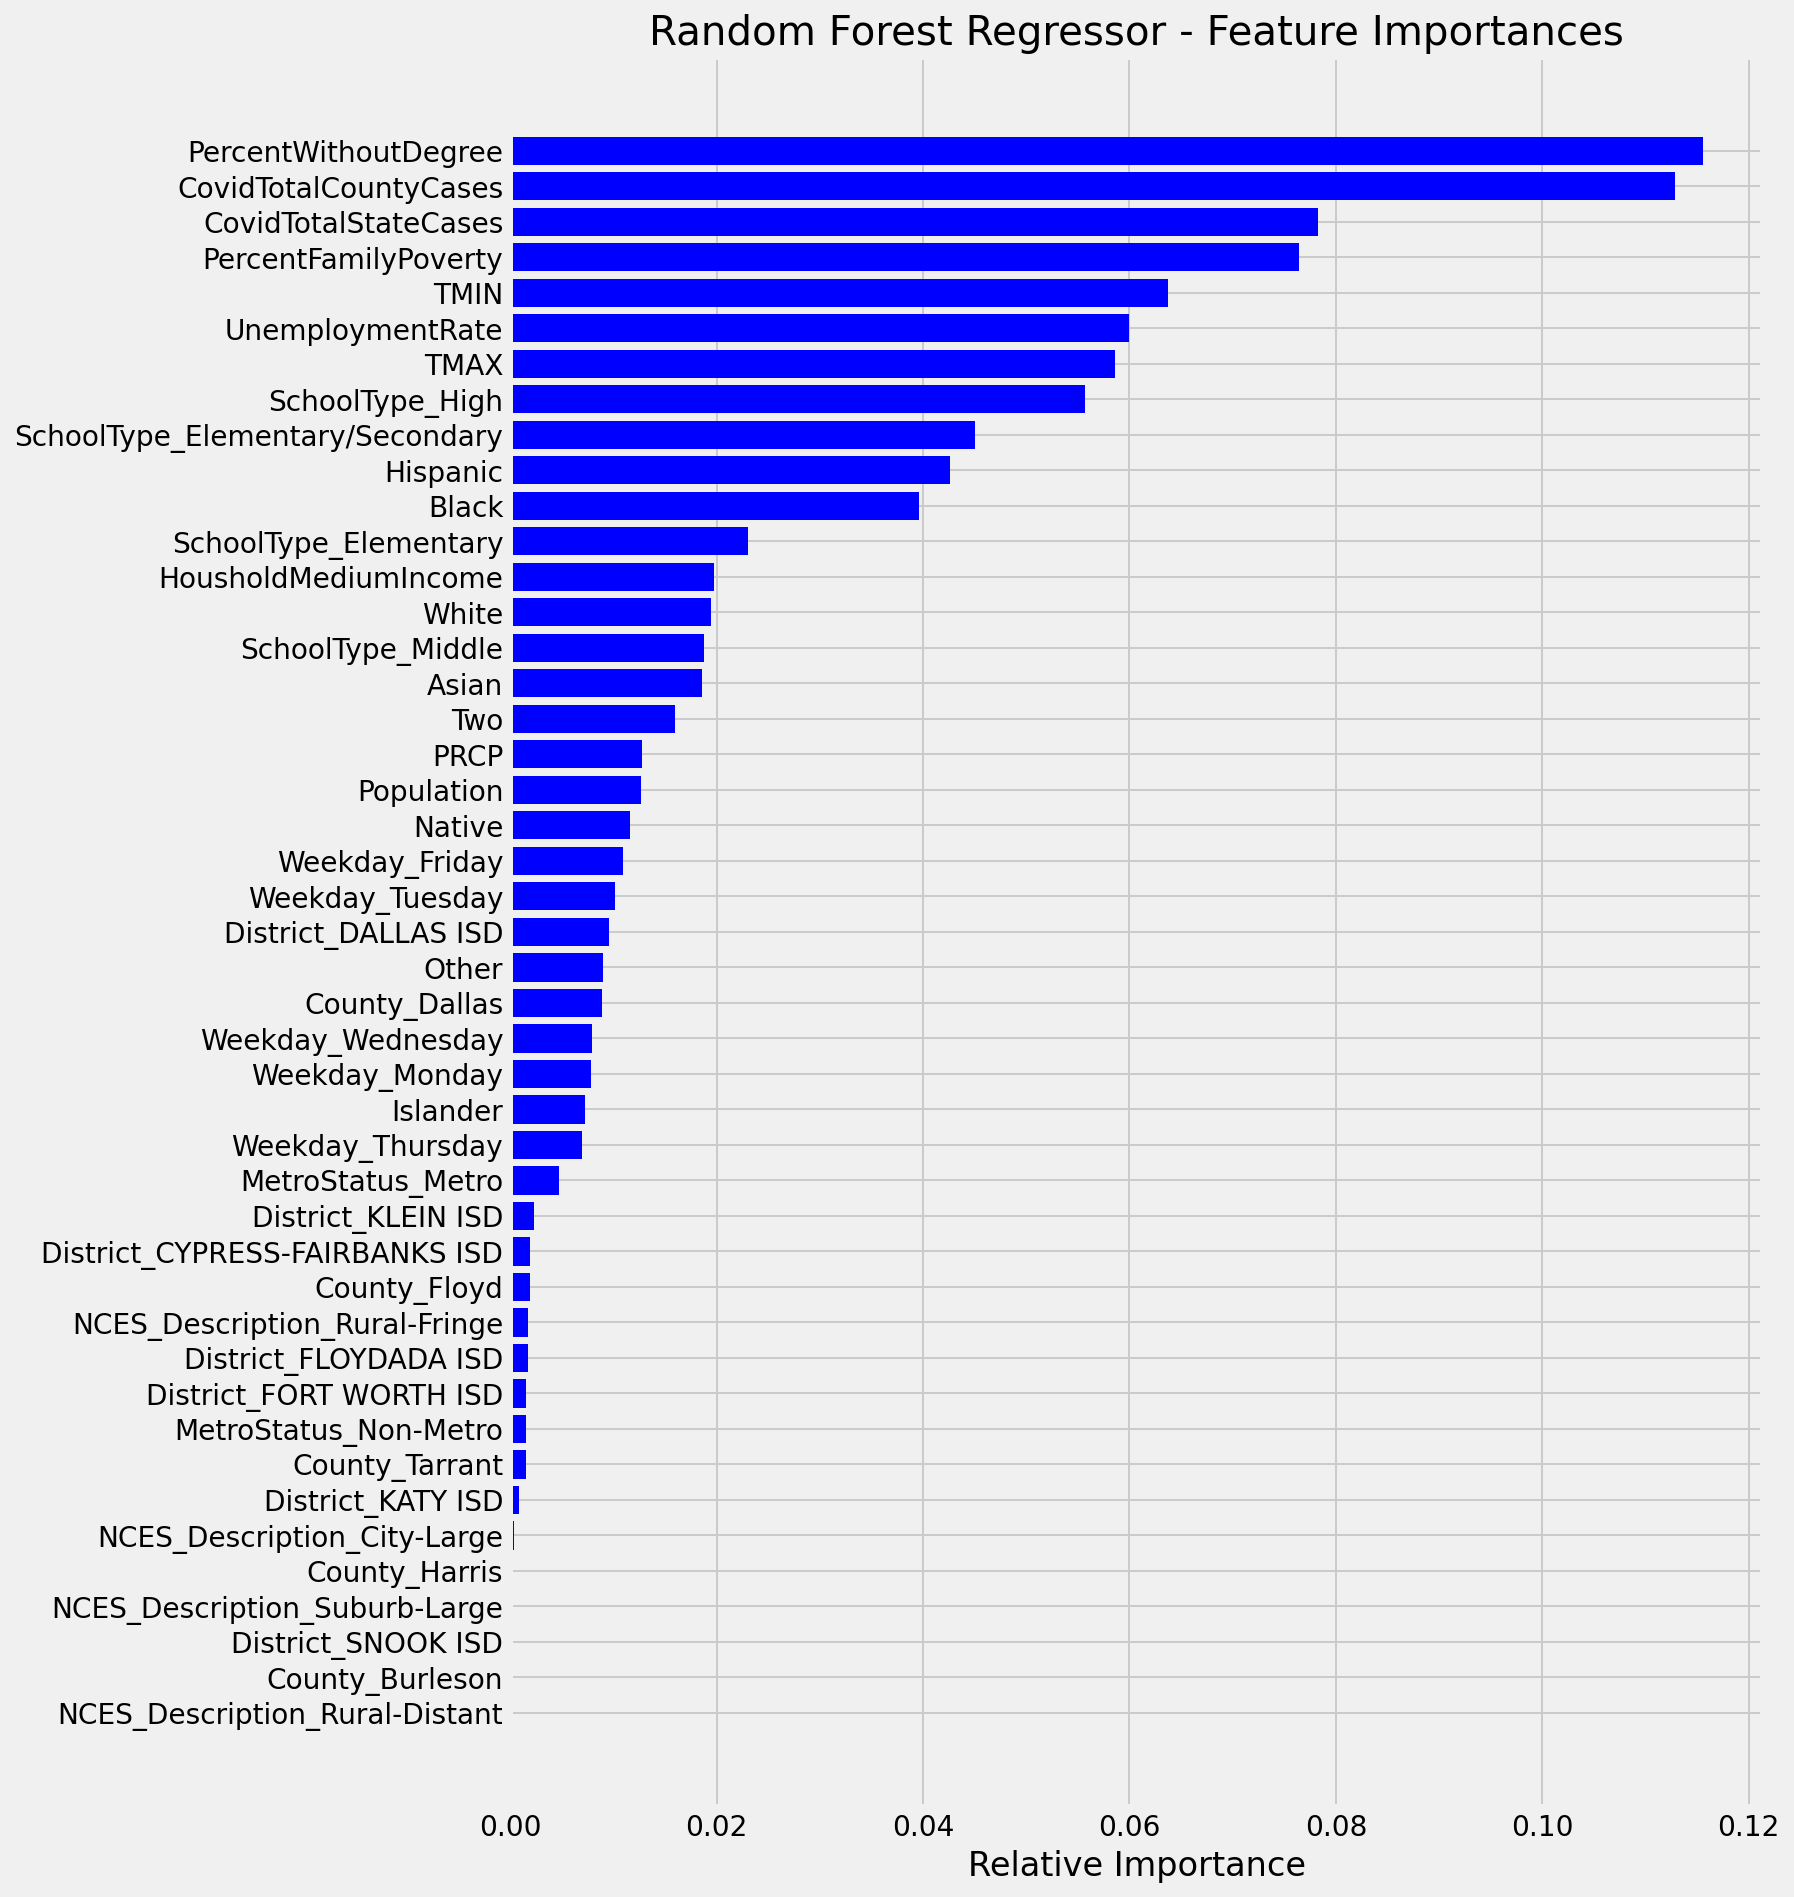

In [27]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15));
plt.title("Random Forest Regressor - Feature Importances");
plt.barh(range(len(indices)), importances[indices], color='b', align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel("Relative Importance");

### Gradient Boosting Regressor with GridSearchCV

In [28]:
# Gradient Boosting Regressor

# instantiate
gb = GradientBoostingRegressor()
parameters = {'n_estimators' : [300, 400, 500],
              'learning_rate' : [0.05, 0.1, 0.2, 0.3]}
gscv_gb = GridSearchCV(gb, param_grid = parameters, cv = 5)

# fit
gscv_gb.fit(X_train, y_train)

# return the best model
gscv_gb.best_estimator_

GradientBoostingRegressor(learning_rate=0.2, n_estimators=500)

In [29]:
gscv_gb.best_params_

{'learning_rate': 0.2, 'n_estimators': 500}

In [30]:
# predict
y_train_preds = gscv_gb.best_estimator_.predict(X_train)
y_test_preds = gscv_gb.best_estimator_.predict(X_test)

# score
print("Training scores:")
print("R2 score: {}".format(r2_score(y_train, y_train_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_train, y_train_preds))))
print("")
print("Testing scores:")
print("R2 score: {}".format(r2_score(y_test, y_test_preds)))
print("RMSE score: {}".format(np.sqrt(mean_squared_error(y_test, y_test_preds))))

Training scores:
R2 score: 0.5867364807148532
RMSE score: 3.6219262867830277

Testing scores:
R2 score: 0.48783523768027315
RMSE score: 4.152474569995002


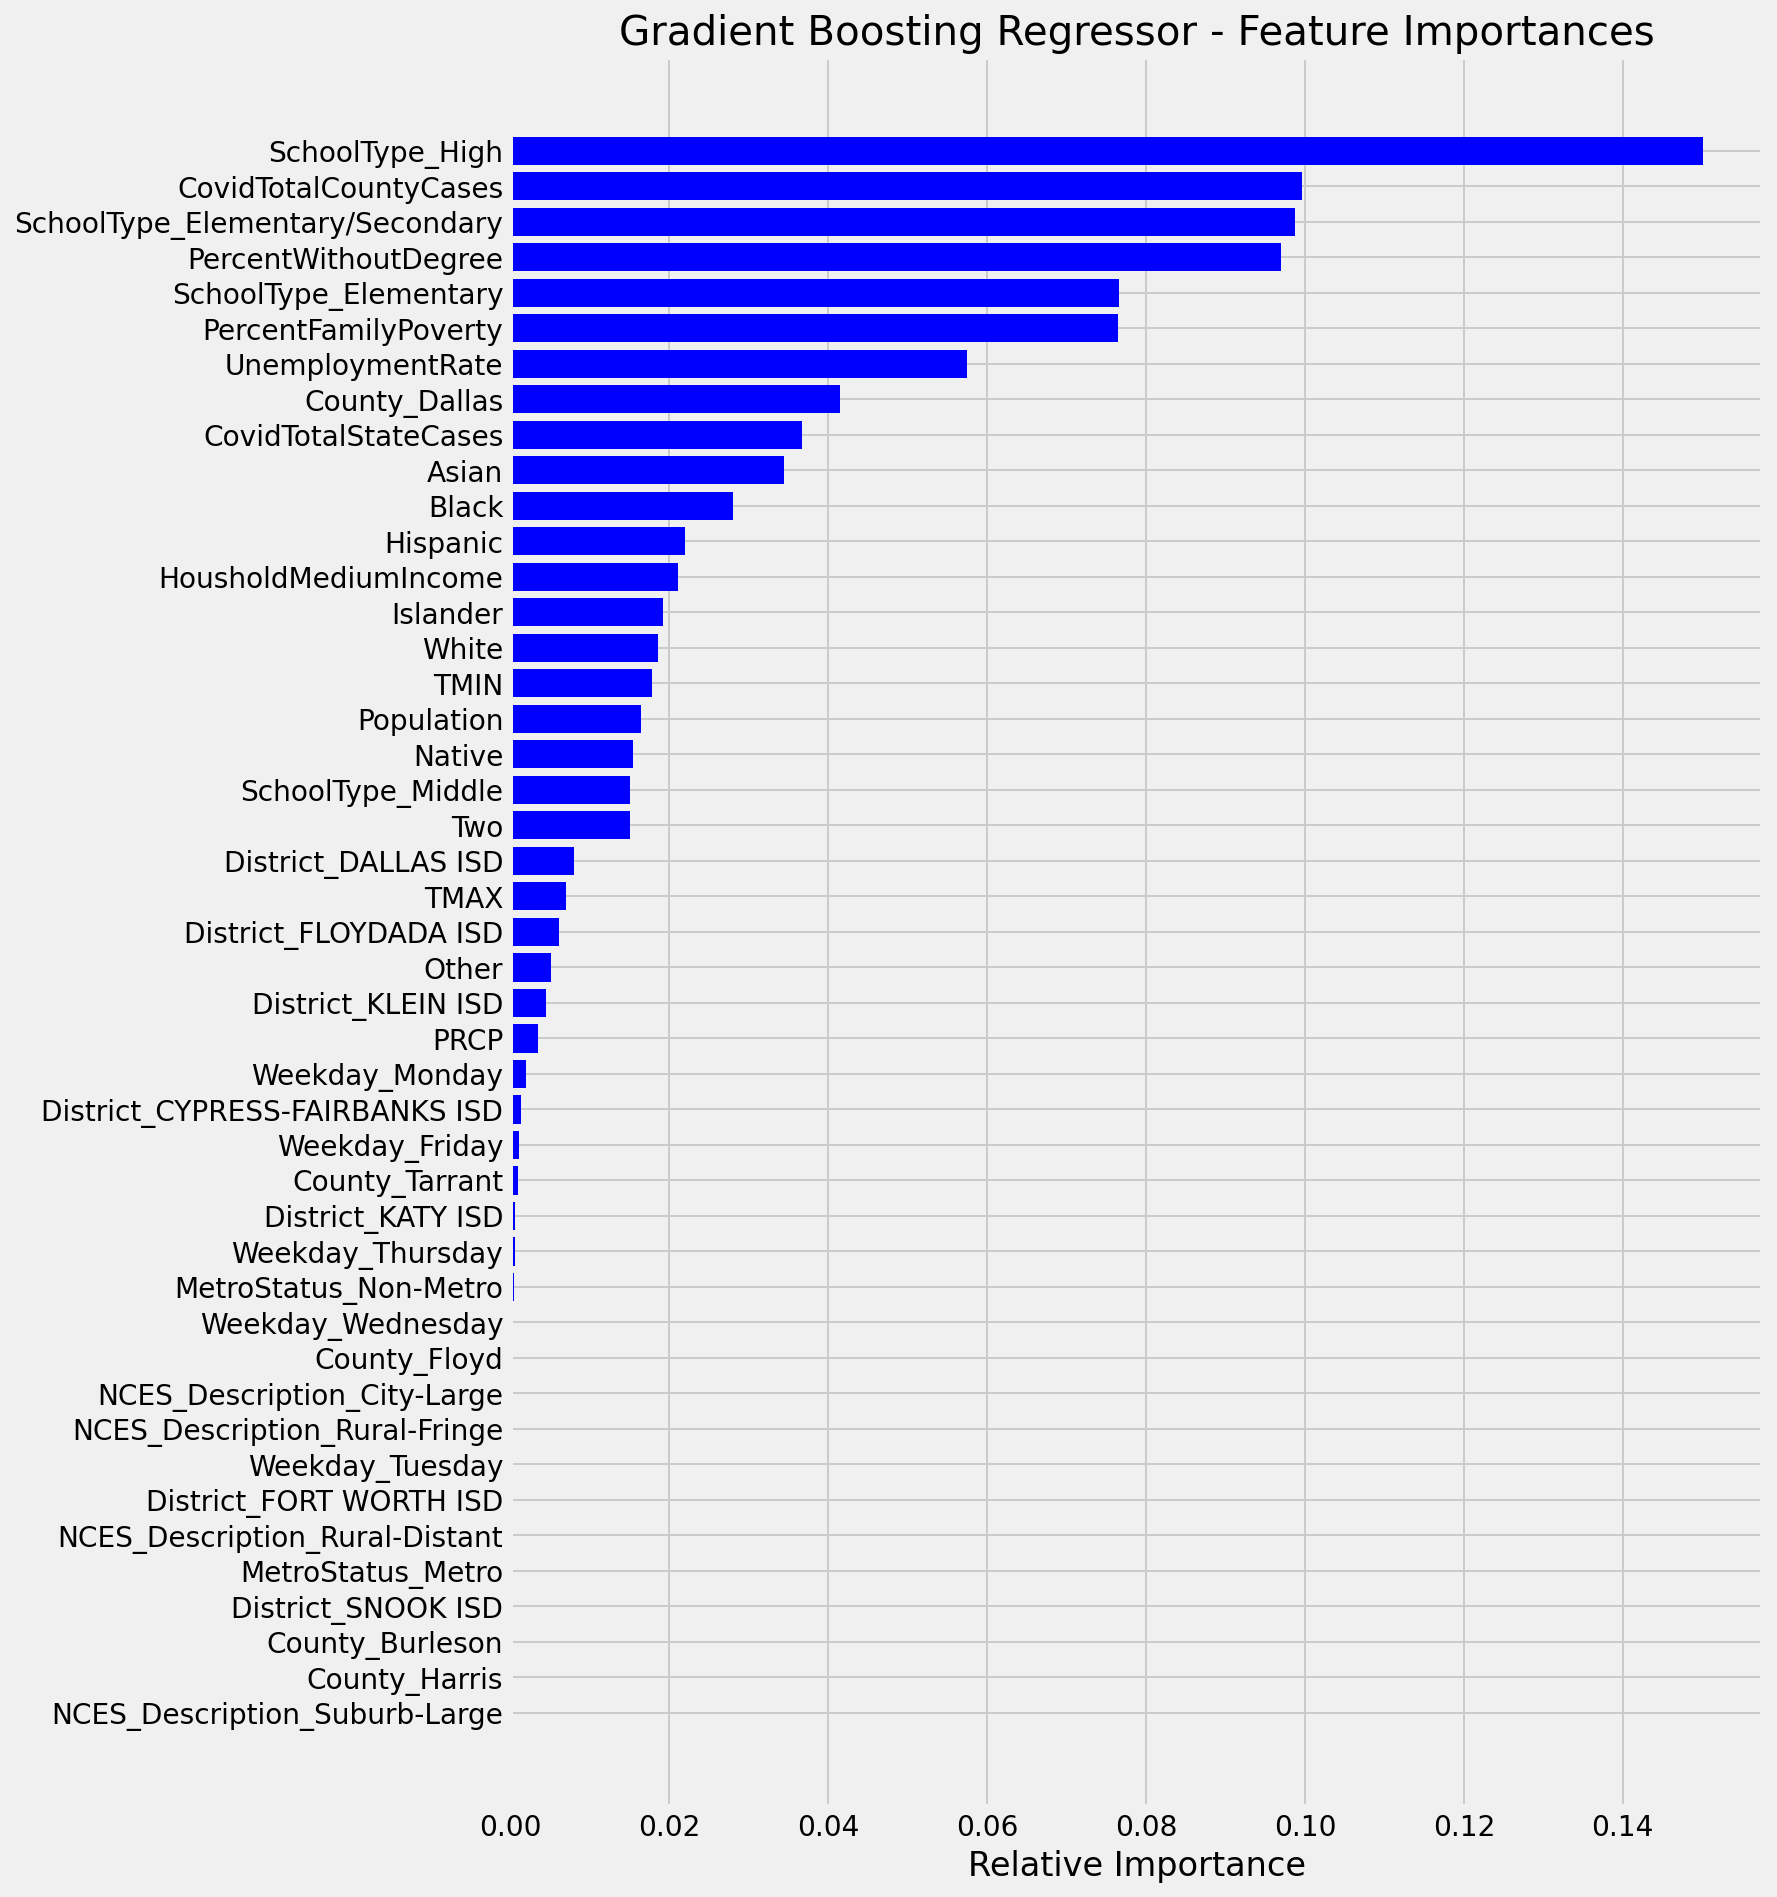

In [31]:
features = X.columns
importances = gscv_gb.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15));
plt.title("Gradient Boosting Regressor - Feature Importances");
plt.barh(range(len(indices)), importances[indices], color='b', align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel("Relative Importance");

## Based on my models and R2 scores above, the best predictive model for my test data is:
### 1st place: Gradient Boosting Regressor (learning_rate = 0.2, n_estimators = 500)
### 2nd place: Random Forest Regressor (n_estimators = 1000)
### 3rd place: Linear Regression (80/20 train/test split)
### 4th place: KNN (n_neighbors = 24, weights = 'uniform')